In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os,shutil
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

import keras
from keras import layers
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [82]:
tf.__version__

'2.5.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
classes = []
for i in os.listdir('/content/drive/MyDrive/nirscene1'):
  classes.append(i)
print(classes)

['field', 'water', 'street', 'oldbuilding', 'urban', 'country', 'indoor', 'mountain', 'forest']


In [ ]:
for c in classes:
  os.makedirs(os.path.join('/content/drive/MyDrive/rgb_images'+'/'+c))
  os.makedirs(os.path.join('/content/drive/MyDrive/nir_images'+'/'+c))

In [ ]:
# Function to segregate rgb and nir data into different directories.

def split_images(path,label):
  nir_path_destination = "/content/drive/MyDrive/nir_images/"+label
  rgb_path_destination = "/content/drive/MyDrive/rgb_images/"+label
  nir_images = []
  rgb_images = []
  for i in os.listdir(path):
    if '_nir' in i:
      nir_images.append(i)
    else:
      rgb_images.append(i)
  

  for n in nir_images:
    shutil.move(path+'/'+n,nir_path_destination)
  
  for r in rgb_images:
    shutil.move(path+'/'+r,rgb_path_destination)

In [ ]:
for c in classes:
  split_images('/content/drive/MyDrive/nirscene1'+'/'+c,c)

In [ ]:
#tiff to jpg converter
def tiff2jpg():
  nir_path = '/content/drive/MyDrive/nir_images/'
  rgb_path = '/content/drive/MyDrive/rgb_images/'
  for label in classes:
    for image in os.listdir(nir_path+label):
      im = Image.open(nir_path+'{}/{}'.format(label,image))
      im.save(nir_path+'{}/{}.jpg'.format(label,image))
      os.remove(nir_path+'{}/{}'.format(label,image))
    for image in os.listdir(rgb_path+label):
      im = Image.open(rgb_path+'{}/{}'.format(label,image))
      im.save(rgb_path+'{}/{}.jpg'.format(label,image))
      os.remove(rgb_path+'{}/{}'.format(label,image))
      
tiff2jpg()


In [5]:
# Pre process data
data_dir_rgb = "/content/drive/MyDrive/rgb_images"
data_dir_nir = "/content/drive/MyDrive/nir_images"

img_height = 128
img_width = 128
batch_size = 32

train_rgb_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_rgb,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_rgb_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_rgb,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_nir_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_nir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_nir_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_nir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 477 files belonging to 9 classes.
Using 382 files for training.
Found 477 files belonging to 9 classes.
Using 95 files for validation.
Found 477 files belonging to 9 classes.
Using 382 files for training.
Found 477 files belonging to 9 classes.
Using 95 files for validation.


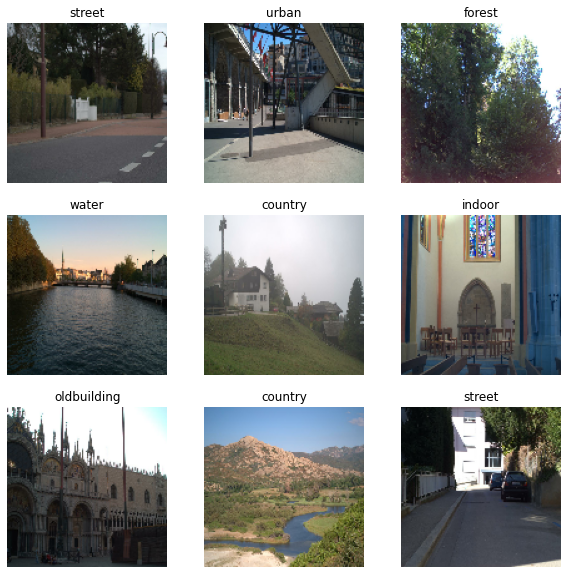

In [6]:
# Visualization of the RGB Dataset

class_names = train_rgb_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_rgb_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

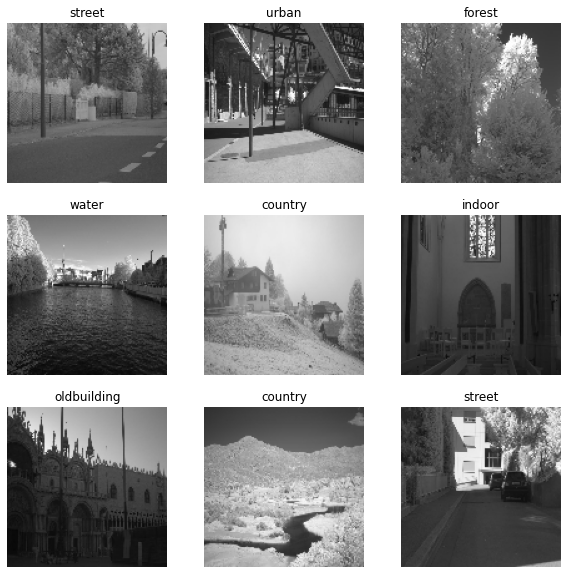

In [7]:
# Visualization of the NIR Dataset

class_names = train_nir_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_nir_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# RGB Image shape
for image_batch, labels_batch in train_rgb_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [9]:
# NIR Image shape
for image_batch, labels_batch in train_nir_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 128, 128, 3)
(32,)


In [10]:
#Normalization Layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
# Standardization of RGB
normalized_train_rgb_ds = train_rgb_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_rgb_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0032935052 1.0


In [14]:
# Standardization of NIR
normalized_train_nir_ds = train_nir_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_nir_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.17045037 0.99859077


In [23]:
# Standardization of RGB & NIR test

normalized_test_nir_ds = val_nir_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_test_nir_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_test_rgb_ds = val_rgb_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_test_rgb_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13180147 0.9176471
0.02401195 1.0


In [59]:
input_shape = tf.keras.Input(shape=(128,128,3))
print(input_shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [91]:
#Model Building

def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)
    
  return model

In [92]:
# Multi channel Model implementation
num_classes = 9
img_rows = 128
img_cols = 128
in_channel = 3
input_shape = (img_rows, img_cols, in_channel)

rgb_input = Input(shape=input_shape)
rgb_model = create_convolution_layers(rgb_input)

nir_input = Input(shape=input_shape)
nir_model = create_convolution_layers(nir_input)

conv = concatenate([rgb_model, nir_model])
conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[rgb_input, nir_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [61]:
output

<KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'dense_7')>

In [73]:
#training data
train_image_batch_nir, train_labels_batch_nir = next(iter(normalized_train_nir_ds))
train_image_batch_rgb, train_labels_batch_rgb = next(iter(normalized_train_rgb_ds))

#test data
test_image_batch_nir, test_labels_batch_nir = next(iter(normalized_test_nir_ds))
test_image_batch_rgb, test_labels_batch_rgb = next(iter(normalized_test_rgb_ds))

In [75]:

class_train = train_labels_batch_rgb.numpy()
class_test = test_labels_batch_rgb.numpy()

In [84]:
train_labels = tf.keras.utils.to_categorical(class_train, num_classes)
test_labels = tf.keras.utils.to_categorical(class_test, num_classes)

In [93]:
# Train the model - (work needed do not run)
batch_size = 32
epochs = 100


model.fit([train_image_batch_rgb, train_image_batch_nir], train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([test_image_batch_rgb, test_image_batch_nir], test_labels),
          shuffle=True)

Epoch 1/100
1/1 [==============================] - 66s 66s/step - loss: 2.3237 - accuracy: 0.0625 - val_loss: 14.8652 - val_accuracy: 0.1562
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 23.5037 - accuracy: 0.3125 - val_loss: 7.5016 - val_accuracy: 0.0938
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 14.1745 - accuracy: 0.2188 - val_loss: 3.5381 - val_accuracy: 0.1562
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 7.1056 - accuracy: 0.1875 - val_loss: 2.3314 - val_accuracy: 0.0938
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 3.3899 - accuracy: 0.2500 - val_loss: 2.8160 - val_accuracy: 0.1250
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 2.5129 - accuracy: 0.3125 - val_loss: 3.1569 - val_accuracy: 0.1250
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 3.0712 - accuracy: 0.2812 - val_loss: 2.3703 - val_accuracy: 0.1250
Epoch 8/100
1/1 [============

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 32) 896         input_2[0][0]                    
______________________________________________________________________________________________